Demonstration of randomized search to compare classifier performance
============================================================================
An important step in classifier performance comparison is hyperparameter 
optimization. Here, we specify the classifer models we want to tune and a 
dictionary of hyperparameter ranges (preferably similar for fairness in 
comparision) for each classifier. Then, we find the optimal hyperparameters 
through a function that uses RandomizedSearchCV and refit the optimized 
models to obtain accuracies. 


In [6]:
# @vivek: use a better method for sorting imports. i recommend `isort`
# @vivek: are all imports actually being used? remove unused imports (like `math`)

print(__doc__)

from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import math
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn import metrics

from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score, make_scorer

Automatically created module for IPython interactive environment


In [20]:
# @vivek: nice docstring! it's very informative and helpful.
# @vivek: make sure you adhere to a line length (<80-88 characters). helps with readibility.

# @vivek: this function is pretty long. to improve it, I would split it into 
# two different functions: one that saves the parameters and one that plots the results

def hyperparameter_optimization_grid(X, y, *argv):
    """
    Given a classifier and a dictionary of hyperparameters, find optimal hyperparameters using GridSearchCV.

    Parameters
    ----------
    X : numpy.ndarray
        Input data, shape (n_samples, n_features)
    y : numpy.ndarray
        Output data, shape (n_samples, n_outputs)
    *argv : list of tuples (classifier, hyperparameters)
        List of (classifier, hyperparameters) tuples:

        classifier : sklearn-compliant classifier
            For example sklearn.ensemble.RandomForestRegressor, rerf.rerfClassifier, etc
        hyperparameters : dictionary of hyperparameter ranges
            See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html. 

    Returns
    -------
    clf_best_params : dictionary
        Dictionary of best hyperparameters
    """

    clf_best_params = {}
    clf_results = {}

    kappa_scorer = make_scorer(cohen_kappa_score)

    # Iterate over all (classifier, hyperparameters) pairs
    for clf, params in argv:

        # Run grid search
        grid_search = GridSearchCV(
            clf, param_grid=params, scoring=kappa_scorer, cv=10, iid=False
        )
        grid_search.fit(X, y)

        # Save results
        clf_best_params[clf] = grid_search.best_params_
        pair_arrays = []
        # @vivek: would be better to iterate over the dictionary keys themselves
        for i in range(len(params)-1):
            for j in range(len(params)-1):
                param1_name = list(extraTrees_param_dict.keys())[i]
                param2_name = list(extraTrees_param_dict.keys())[j+1]
                param1 = extraTrees_param_dict[param1_name]
                param2 = extraTrees_param_dict[param2_name]
                scores = grid_search.cv_results_['mean_test_score'].reshape(len(param1), len(param2))
                pair_arrays.append(scores)
                
                # @vivek: use more descriptive variable names
                a = -np.array(scores)
                # @vivek: what is this doing? kinda opaque
                a = a.ravel().argsort().argsort().reshape(a.shape)
                
                # @vivek: I would move plotting to another function
                plt.figure(figsize=(8, 6))
                plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
                plt.imshow(a, interpolation='nearest', cmap=plt.cm.hot)
                plt.xlabel(param2_name)
                plt.ylabel(param1_name)
                plt.colorbar()
                plt.xticks(np.arange(len(param2)), param2)
                plt.yticks(np.arange(len(param1)), param1)
                plt.title('Grid Search Kappa Rank ' + str(clf))
                plt.show()
                
        clf_results[clf] = pair_arrays    

        
    return clf_best_params, clf_results

# Building classifiers and specifying parameter ranges to sample from


In [4]:
# get some data
X, y = fetch_openml(data_id=40975, return_X_y=True, as_frame=True) #car dataset
y = pd.factorize(y)[0]
X = X.apply(lambda x: pd.factorize(x)[0])

# @vivek: you can rewrite these lines as:
# `n_samples, n_features = np.shape(X)`
# python automatically unzips tuples for you!
n_features = np.shape(X)[1]
n_samples = np.shape(X)[0]


# build a classifier
extraTrees = ExtraTreesClassifier()


# @vivek: watch the indentation length here. should just be 1 tab length

# specify parameters and distributions to sample from
extraTrees_param_dict = {
        "max_features": ["sqrt", "log2", None],
        "n_estimators": [50,100,150,200],
}

# build another classifier
rf = RandomForestClassifier()

# specify parameters and distributions to sample from
rf_param_dict = {
        "max_features": ["sqrt", "log2", None],
        "n_estimators": [50,100,150,200],
}

3


# Obtaining best parameters dictionary and refitting

[[11  9  4 10]
 [ 8  7  5  6]
 [ 1  3  0  2]]


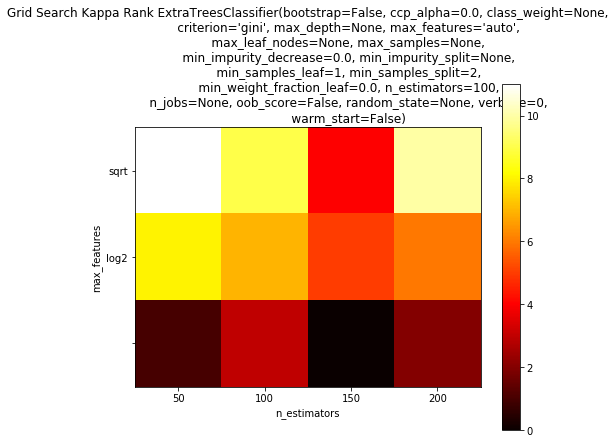

[[ 8  9  5  6]
 [ 3 10 11  4]
 [ 7  2  0  1]]


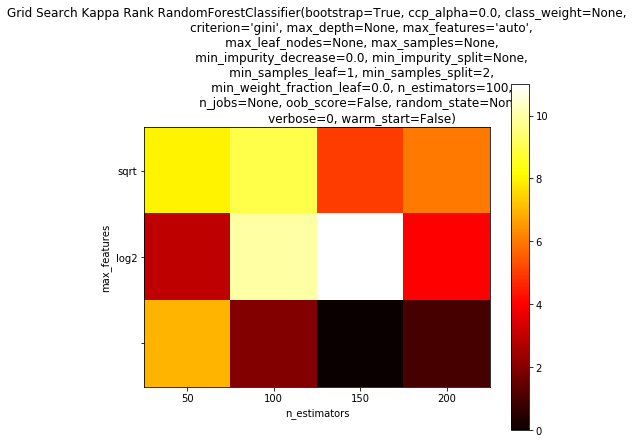

{ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False): {'max_features': None, 'n_estimators': 150}, RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100

In [21]:
best_params, results = hyperparameter_optimization_grid(
    X, y, (extraTrees, extraTrees_param_dict), (rf, rf_param_dict)
)
print(best_params)
print(results)

# extract values from dict - seperate each classifier's param dict
keys, values = zip(*best_params.items())

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [27]:
# get accuracies of optimized and default models

# @vivek: there has to be a bug in here... it's very unlikely that the accuracies are equal
# @vivek: can this operation be functionalized? looks like the same thing is happening 4 times!

extraTrees_opti = ExtraTreesClassifier(**values[0])
extraTrees_opti.fit(X_train, y_train)
extraTrees_pred_opti = extraTrees_opti.predict(X_test)
extraTrees_acc_opti = metrics.accuracy_score(y_test, extraTrees_pred_opti)

extraTrees_default = ExtraTreesClassifier()
extraTrees_default.fit(X_train, y_train)
extraTrees_pred_default = extraTrees_default.predict(X_test)
extraTrees_acc_default = metrics.accuracy_score(y_test, extraTrees_pred_default)

rf_opti = RandomForestClassifier(**values[1])
rf_opti.fit(X_train, y_train)
rf_pred_opti = rf_opti.predict(X_test)
rf_acc_opti = metrics.accuracy_score(y_test, rf_pred_opti)

rf_default = RandomForestClassifier()
rf_default.fit(X_train, y_train)
rf_pred_default = rf_default.predict(X_test)
rf_acc_default = metrics.accuracy_score(y_test, rf_pred_default)

# Plotting the result

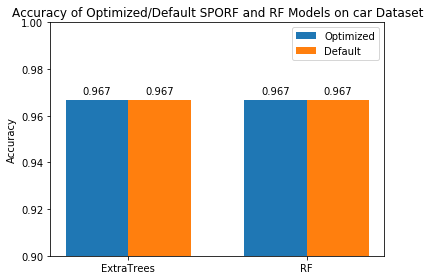

In [28]:
labels = ["ExtraTrees", "RF"]
extraTrees_acc = [extraTrees_acc_opti, extraTrees_acc_default]
rf_acc = [rf_acc_opti, rf_acc_default]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, extraTrees_acc, width, label="Optimized")
rects2 = ax.bar(x + width / 2, rf_acc, width, label="Default")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of Optimized/Default SPORF and RF Models on car Dataset")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = float("%.3f" % (rect.get_height()))
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.ylim((0.9, 1))

plt.show()